# A basic Python implementation of FOCuS for Poisson data

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import root_scalar

class Curve:
    def __init__(self, k_T, lambda_1, t=0):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.
    
    def __repr__(self):
        return f'Curve: {self.a} log(mu) + {self.b} (mu-1), t={self.t}.'
    
    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)
    
    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def xmax(self):
        return -self.a/self.b
    
    def is_negative(self):
        #returns true if slope at mu=1 is negative (i.e. no evidence for positive change)
        return (self.a + self.b) < 0
    
    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)

In [15]:
def focus_step(curve_list, k_T, lambda_1):
    new_curve_list = []
    global_max = 0
    time_offset = 0
    
    if not curve_list: #list is empty
        
        if k_T <= lambda_1:
            return new_curve_list, global_max, time_offset
        else:
            updated_c = Curve(k_T, lambda_1, t=-1)
            new_curve_list.append(updated_c)
            global_max = updated_c.ymax()
            time_offset = updated_c.t
            
    else: #list not empty: go through and prune
        
        updated_c = curve_list[0].update(k_T, lambda_1) #check leftmost quadratic separately
        if updated_c.is_negative(): #our leftmost quadratic is negative i.e. we have no quadratics
            return new_curve_list, global_max, time_offset
        else:
            new_curve_list.append(updated_c)
            if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                global_max = updated_c.ymax()
                time_offset = updated_c.t

            for c in curve_list[1:]+[Curve(0, 0)]:#add on new quadratic to end of list
                updated_c = c.update(k_T, lambda_1)

                if new_curve_list[-1].dominates(updated_c):
                    break #quadratic q and all quadratics to the right of it are pruned out by q's left neighbour
                elif updated_c.is_negative():
                    pass #delete q and move on
                else:
                    new_curve_list.append(updated_c)

                    if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                        global_max = updated_c.ymax()
                        time_offset = updated_c.t
            
            
        
    return new_curve_list, global_max, time_offset

In [16]:
def plot_curves(curve_list, threshold=25, T=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS step at detection time $T=67$")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{T}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+T+1}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

def focus(X, lambda_1, threshold, plot=False):
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)
    
    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T])
        
        if plot:
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.show()
        
        if global_max > threshold:
            return global_max, time_offset+T+1, T
        
    return 0, len(X)+1, len(X) #no change found by end of signal

### Test case

Here's FOCuS running on a randomly generated signal of 50 Poisson points with mean $\lambda_1=2$ then a change to $\lambda_2 = 4$ (i.e. $\mu = 2$) for the next 50 points, with the detection threshold of $5\sigma$.

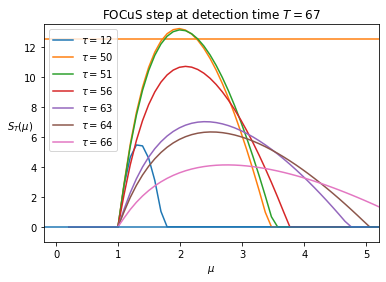

In [17]:
from scipy import stats
np.random.seed(42)
threshold=12.5
X = np.concatenate((stats.poisson(mu=2).rvs(size=50), stats.poisson(mu=4).rvs(size=50)))

significance, changepoint, stopping_time = focus(X, lambda_1=2, threshold=threshold, plot=True) #if you change plot to False it goes a lot faster

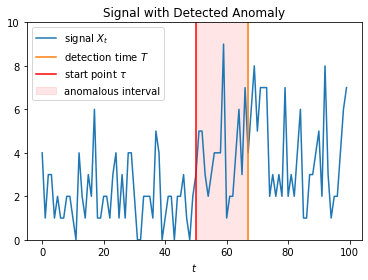

In [18]:
plt.plot(X, label="signal $X_t$")
plt.title("Signal with Detected Anomaly")
plt.xlabel("$t$")
if changepoint is not None:
    plt.fill((changepoint, stopping_time, stopping_time, changepoint), (-5, -5, 15, 15), color="red", alpha=0.1, label="anomalous interval") 
    plt.axvline(stopping_time, color='C1', label="detection time $T$")
    plt.axvline(changepoint, color='red', label="start point $\\tau$")
    plt.ylim(0, 10)
    
    plt.legend()

In [19]:
#np.random.seed(42)
#threshold=12.5
#X = np.concatenate((stats.poisson(mu=1).rvs(size=500000), stats.poisson(mu=4).rvs(size=50)))
#%timeit -n2 -r1 significance, changepoint, stopping_time = focus(X, lambda_1=1, threshold=12.5, plot=False)

In [20]:
stopping_time

67

## Largest Convex Minorant



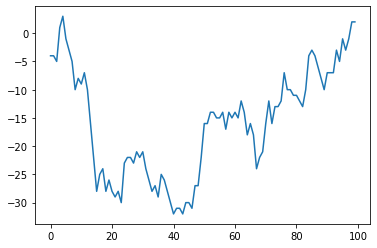

In [21]:
np.random.seed(11)

λ=10
size=100

signal = stats.poisson.rvs(mu=λ, size=size)
offset = np.full(shape=size, fill_value=-λ)

random_walk = signal.cumsum() + offset.cumsum()

plt.plot(random_walk)

In [22]:
def focus_find_curves(X, lambda_1, threshold, plot=False):
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)
    
    output = []
    
    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T])
        
        curve_start_times = []
        for curve in curve_list:
            curve_start_times.append(curve.t+T+1)
        
        output.append(curve_start_times)
        
        if global_max > threshold:
            return global_max, time_offset+T+1, T
        
        
    return output

In [23]:
curve_list = focus_find_curves(signal, lambda_1=λ, threshold=1000)

Text(0.5, 1.0, 'Locations of Changepoint Candidates compared to $Z_t-t\\lambda$')

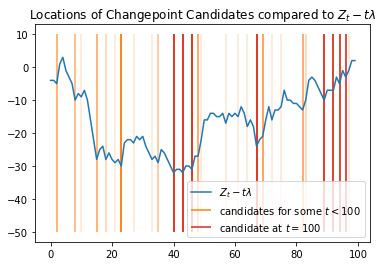

In [47]:
plt.vlines(40, -50, 10, color="C1", alpha=1, label="candidates for some $t<100$")

for T in curve_list:
    changepoint_candidates = np.array(T)-1
    plt.vlines(changepoint_candidates, -50, 10, color="C1", alpha=0.2)
    
E = curve_list[-1]
changepoint_candidates = np.array(E)-1
plt.vlines(changepoint_candidates, -50, 10, color="C3", label="candidate at $t=100$")

plt.plot(random_walk, label="$Z_t-t\lambda$")

plt.legend(loc="lower right")
plt.title("Locations of Changepoint Candidates compared to $Z_t-t\lambda$")

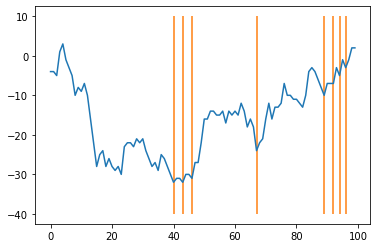

In [27]:
plt.plot(random_walk)
from time import sleep

for T in curve_list:
    clear_output(wait=True)
    plt.plot(random_walk, color="C0")
    changepoint_candidates = np.array(T)-1
    plt.vlines(changepoint_candidates, -40, 10, color="C1")
    plt.show()
    sleep(0.5)